In [14]:
%matplotlib inline
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pykml.factory import KML_ElementMaker as KML
from xml.dom.minidom import parse
import matplotlib as mpl
from lxml import etree
import numpy as np
import re
import zipfile


def get_box(lat, lon):
    box = ''
    ds = gdal.Open(lat, gdal.GA_ReadOnly)
    data = ds.GetRasterBand(1).ReadAsArray()
    box += (str(np.min(data)) + ' ')
    box += (str(np.max(data)) + ' ')
    data = None

    ds = gdal.Open(lon, gdal.GA_ReadOnly)
    data = ds.GetRasterBand(1).ReadAsArray()
    box += (str(np.min(data)) + ' ')
    box += str(np.max(data))
    data = None
    
    return box



def wrap_data(data, wrap_range=[-np.pi, np.pi]):
    w0, w1 = wrap_range
    wrapped_data = w0 + np.mod(data - w0, w1 - w0)
    return wrapped_data


def plot_colorbar(data, cmap, out_dir, figsize, nbins):
    vmin = np.nanmin(data)
    vmax = np.nanmax(data)
    fig, cax = plt.subplots(figsize=figsize)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap)
    cbar = mpl.colorbar.ColorbarBase(cax,
                                     cmap=cmap,
                                     norm=norm,
                                     orientation='vertical')
    cbar.locator = mpl.ticker.MaxNLocator(nbins=nbins)
    cbar.update_ticks()
    cbar.ax.tick_params(which='both', labelsize=12)
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.7)
    out_file = os.path.join(out_dir, 'colorbar.png')
    fig.savefig(out_file,
                bbox_inches='tight',
                facecolor=fig.get_facecolor(),
                dpi=300)


def plot_img(data, cmap, out_dir):
    data[data == 0] = np.nan
    vmin = np.nanmin(data)
    vmax = np.nanmax(data)
    fig = plt.figure(frameon=False)
    ax = fig.add_axes([0., 0., 1., 1.])
    ax.set_axis_off()
    cmap = plt.get_cmap(cmap)
    ax.imshow(data, aspect='auto', vmax=vmax, vmin=vmin, cmap=cmap)
    out_file = os.path.join(out_dir, 'img.png')
    fig.savefig(out_file,
                pad_inches=0.0,
                transparent=True,
                interpolation='nearest',
                dpi=300)


def write_kmz(lon_lat,
              data,
              out_file,
              cmap='jet',
              figsize=(0.18, 3.6),
              nbins=7):
    file = os.path.abspath(out_file)
    if file.endswith('.kmz'):
        file = file[:-4]
    out_dir = os.path.dirname(file)

    plot_colorbar(data, cmap, out_dir, figsize=figsize, nbins=nbins)
    plot_img(data, cmap, out_dir)

    south, north, west, east = lon_lat

    doc = KML.kml(KML.Folder(KML.name(os.path.basename(file))))
    img_displayed = KML.GroundOverlay(
        KML.name(os.path.basename('img')),
        KML.Icon(KML.href(os.path.basename('img.png'))),
        KML.LatLonBox(KML.north(str(north)), KML.south(str(south)),
                      KML.east(str(east)), KML.west(str(west))))
    doc.Folder.append(img_displayed)

    legend = KML.ScreenOverlay(
        KML.name('colorbar'),
        KML.Icon(KML.href(os.path.basename('colorbar.png')),
                 KML.viewBoundScale(0.75)),
        KML.overlayXY(
            x="0.0",
            y="1",
            xunits="fraction",
            yunits="fraction",
        ), KML.screenXY(
            x="0.0",
            y="1",
            xunits="fraction",
            yunits="fraction",
        ),
        KML.rotationXY(
            x="0.",
            y="1.",
            xunits="fraction",
            yunits="fraction",
        ), KML.size(
            x="0",
            y="250",
            xunits="pixel",
            yunits="pixel",
        ), KML.visibility(1), KML.open(0))

    doc.Folder.append(legend)

    kml_str = etree.tostring(doc, pretty_print=True)
    kml_name = file + '.kml'
    with open(kml_name, 'wb') as f:
        f.write(kml_str)

    kmz_name = file + '.kmz'
    with zipfile.ZipFile(kmz_name, 'w') as f:
        os.chdir(out_dir)
        f.write(os.path.basename(kml_name))
        os.remove(os.path.basename(kml_name))
        f.write('img.png')
        os.remove('img.png')
        f.write('colorbar.png')
        os.remove('colorbar.png')

## geocode

In [19]:
merged_dir = '/media/chenjiajun/新加卷/sc_stack/sc21/isce_stack/merged'
ifg_date = '20190128_20190209'



unw_dir = os.path.join(merged_dir, 'interferograms', ifg_date)
lat = os.path.join(merged_dir, 'geom_reference', 'lat.rdr')
lon = os.path.join(merged_dir, 'geom_reference', 'lon.rdr')
box = get_box(lat, lon)
os.chdir(unw_dir)
cmd_str = f"geocodeGdal.py -l '{lat}' -L '{lon}' -f filt_fine.unw -b '{box}'"
os.system(cmd_str)

0

## read and plot

<ipython-input-20-7a9777da8e0a>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


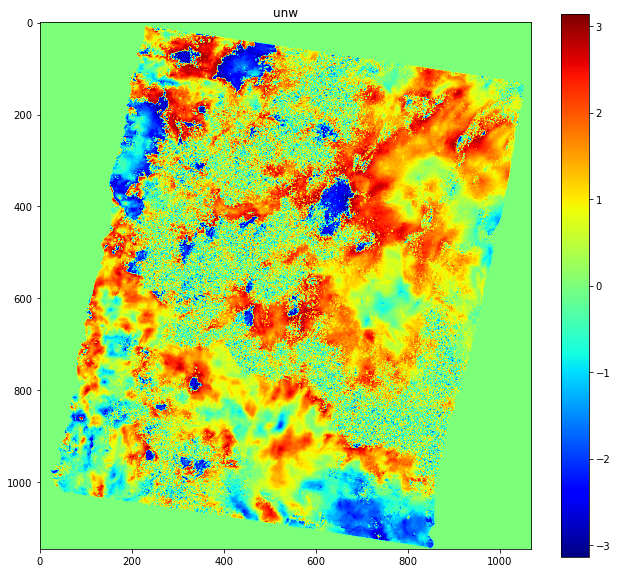

In [20]:
os.chdir(unw_dir)


ds = gdal.Open('geo_filt_fine.unw', gdal.GA_ReadOnly)
data = ds.GetRasterBand(2).ReadAsArray()
ds = None

fig,ax = plt.subplots(figsize=(11,10))
im = ax.imshow(wrap_data(data), cmap='jet')
fig.colorbar(im)
ax.set_title('unw')
fig.show()

## make kmz

<ipython-input-14-f6f09831a9e2>:75: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,


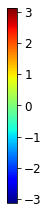

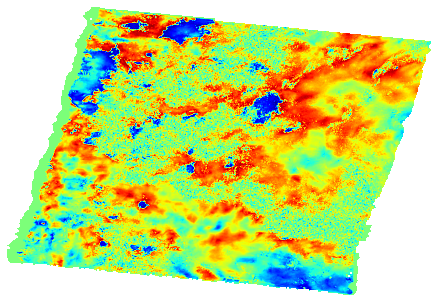

In [21]:
lon_lat = box.split()

out_file = os.path.join(merged_dir, ifg_date)

write_kmz(lon_lat, wrap_data(data), out_file, cmap='jet')